# Data Transformation Exploration (raw CSV → model-ready)

This notebook helps you validate the **data transformation pipeline** step-by-step before fitting Bayesian models.

## What you’ll get confidence in

- Input files load correctly
- Retailer-specific parsing rules are applied correctly (Circana vs Costco CRX)
- Expected columns exist after transformation
- Prices / sales / logs look sensible (no weird zeros, negative values, or extreme outliers)
- Retailer separation behaves as expected (`retailer_filter`)
- “Missing feature” masking works (e.g., Costco missing competitor / private label)
- You can export an auditable `prepared_data_from_notebook.csv`

## Prereqs

- Place your raw files in `data/`:
  - `data/bjs.csv`
  - `data/sams.csv`
  - `data/costco.csv` (optional)

- Install dependencies:

```bash
pip install -r requirements.txt
```

## Costco note

Costco CRX typically has a different schema than Circana. The pipeline handles this via **runtime YAML retailer contracts** (`data.retailer_data_contracts` in `config_template.yaml`). This notebook will attempt to load those contracts so Costco is parsed correctly.


## Notebook environment setup (imports + paths + outputs)

**What this cell does**
- Imports standard libraries (pandas/numpy/matplotlib).
- Detects the repo root (`REPO_ROOT`) and adds it to `sys.path` so local imports work.
- Imports `ElasticityDataPrep` and `PrepConfig` from `data_prep.py`.
- Creates a `results/` directory for notebook outputs.

**Why we do it**
- Notebooks can be run from different working directories; this makes imports and paths reliable.
- Ensures exports (CSV artifacts) have a consistent destination.

**What to look for**
- Printed `repo root:` points to the project root (not `notebooks/`).
- `results/ directory:` exists and is writable.


In [ ]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure repo root is on PYTHONPATH so imports work regardless of notebook CWD
REPO_ROOT = Path.cwd()
if (REPO_ROOT / "data_prep.py").exists() is False:
    # If we're running from notebooks/, go one level up
    REPO_ROOT = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path.cwd().parents[0]

if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

from data_prep import ElasticityDataPrep, PrepConfig

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 180)

# Where outputs from this notebook will go
RESULTS_DIR = REPO_ROOT / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print("Notebook environment ready")
print("repo root:", REPO_ROOT.resolve())
print("results/ directory:", RESULTS_DIR.resolve())


Notebook environment ready
repo root: C:\repos\tr-price-elasticity-bayesian
results/ directory: C:\repos\tr-price-elasticity-bayesian\results


## Transform raw retailer CSVs into model-ready features

**What this cell does**
- Sets input file paths for BJ’s / Sam’s / Costco (Costco is optional).
- Loads retailer-specific parsing contracts from `config_template.yaml` (important for Costco CRX schema).
- Builds a `PrepConfig` (seasonality, promotions, trend, base-vs-promo split, Volume Sales DV rules).
- Runs `ElasticityDataPrep.transform(...)` to produce the final prepared dataframe `df`.

**Why we do it**
- This is the “single source of truth” transformation pipeline used by modeling scripts.
- Centralizing config here helps you debug data issues *before* running expensive Bayesian sampling.

**What to look for**
- The logs show each retailer loads successfully.
- `df.shape` looks reasonable (not tiny / not zero rows).
- No warnings about missing critical columns (sales, price, date) unless expected.


In [40]:
# ---- Configure paths (edit if your filenames differ) ----
# IMPORTANT: use absolute paths anchored at REPO_ROOT so this works even if Jupyter's CWD is notebooks/
BJS_PATH = str(REPO_ROOT / "data" / "bjs.csv")
SAMS_PATH = str(REPO_ROOT / "data" / "sams.csv")

# Auto-include Costco if the file exists (you can also hardcode a path string here)
_default_costco = REPO_ROOT / "data" / "costco.csv"
COSTCO_PATH = str(_default_costco) if _default_costco.exists() else None

print("BJS_PATH:", BJS_PATH)
print("SAMS_PATH:", SAMS_PATH)
print("COSTCO_PATH:", COSTCO_PATH)

# Fail fast with a clear error if required inputs are missing
for p in [BJS_PATH, SAMS_PATH] + ([COSTCO_PATH] if COSTCO_PATH else []):
    if p and not Path(p).exists():
        raise FileNotFoundError(f"Missing input file: {p}")

# ---- Load runtime retailer contracts from config_template.yaml (recommended) ----
# These contracts are what allow Costco CRX (different schema) to be parsed correctly.
retailer_data_contracts = None
try:
    import yaml

    cfg_path = REPO_ROOT / "config_template.yaml"
    if cfg_path.exists():
        with open(cfg_path, "r") as f:
            cfg_yaml = yaml.safe_load(f) or {}
        retailer_data_contracts = (cfg_yaml.get("data") or {}).get("retailer_data_contracts")
        print("Loaded retailer_data_contracts from:", cfg_path)
    else:
        print("WARNING: config_template.yaml not found; proceeding without retailer_data_contracts")
except Exception as e:
    print("WARNING: could not load retailer_data_contracts (continuing without it). Error:", e)

# ---- Configure data preparation ----
# Use retailer_filter="All" to keep retailers separate (needed for hierarchical model).
# Use retailer_filter="Overall" to combine into one pooled dataset.

retailers_cfg = {
    "BJs": {"has_promo": True, "has_competitor": True},
    "Sams": {"has_promo": True, "has_competitor": True},
}

# Costco CRX typically has promo depth inputs but does not include Private Label rows for cross-price.
if COSTCO_PATH is not None:
    retailers_cfg["Costco"] = {"has_promo": True, "has_competitor": False}

cfg = PrepConfig(
    retailer_filter="All",
    include_seasonality=True,
    include_promotions=True,
    include_time_trend=True,

    # V2: enable base vs promo separation (default-on in the library)
    separate_base_promo=True,

    # Base price estimation guardrails (used if base sales cols are missing/undefined)
    base_price_proxy_window=8,
    base_price_imputed_warn_threshold=0.30,

    # Dependent variable rule: always model Volume Sales.
    # If a retailer file is missing `Volume Sales`, data prep computes:
    #   Volume Sales = Unit Sales × factor
    # Costco CRX commonly needs this.
    volume_sales_factor_by_retailer={"Costco": 2.0},

    retailers=retailers_cfg,
    retailer_data_contracts=retailer_data_contracts,
    verbose=True,
)

prep = ElasticityDataPrep(cfg)

df = prep.transform(
    bjs_path=BJS_PATH,
    sams_path=SAMS_PATH,
    costco_path=COSTCO_PATH,
)

df.shape

STARTING DATA TRANSFORMATION

Step 1: Loading data...
  Loading BJ's... (skiprows=2)


  Loading Sam's Club... (skiprows=2)
  Loading Costco... (skiprows=1)


BJS_PATH: c:\repos\tr-price-elasticity-bayesian\data\bjs.csv
SAMS_PATH: c:\repos\tr-price-elasticity-bayesian\data\sams.csv
COSTCO_PATH: c:\repos\tr-price-elasticity-bayesian\data\costco.csv
Loaded retailer_data_contracts from: c:\repos\tr-price-elasticity-bayesian\config_template.yaml


    Renamed 'Item' → 'Product'
  Loaded 2886 rows

Step 2: Cleaning data...
    BJ's: Avg_Price from 'Dollar Sales' / 'Unit Sales'
    Costco: Avg_Price from column 'Avg Net Price'
    Costco: Volume Sales computed as Unit Sales x 2.0
    BJ's: Base_Price from 'Base Dollar Sales / Base Unit Sales'
    Costco: Base price fallback applied for 1 rows where Non Promoted Units < 500
    Costco: Base_Price from 'Non Promoted Dollars / Non Promoted Units'
  Cleaned to 1115 rows

Step 3: Creating features...
  Final: 479 rows x 21 columns

Step 4: Validating...
  ✓ Validation passed

✓ TRANSFORMATION COMPLETE


(479, 21)

## Quick inspection (preview + column inventory)

**What this cell does**
- Displays the first ~10 rows of the prepared dataframe.
- Prints the full sorted list of columns.

**Why we do it**
- Ensures the transformation produced the expected schema before we run deeper checks.
- Helps you quickly spot obvious parsing problems (bad dates, wrong retailer labels, missing sales/price columns).

**What to look for**
- `Date` parses correctly, `Retailer` values are clean, and sales/price columns are populated.
- Expected columns exist (e.g., `Volume_Sales_SI`, `Price_SI`, log columns, promo/base columns if enabled).


In [41]:
# ---- Quick inspection ----
display(df.head(10))

# Columns
cols = sorted(df.columns.tolist())
print(f"Columns ({len(cols)}):")
print(cols)


,Date,Retailer,Volume_Sales_PL,Volume_Sales_SI,Price_PL,Price_SI,Private Label,Base_Price_SI,Promo_Intensity_SI,Week_Number,Month,Spring,Summer,Fall,Promo_Depth_SI,Log_Volume_Sales_SI,Log_Price_SI,Log_Price_PL,Log_Base_Price_SI,has_promo,has_competitor
1,2023-01-08,BJ's,87991.867200,23552.000000,10.245911,18.324737,10.254282,18.342658,0.800781,1,1,0,0,0,-0.000977,10.066966,2.908252,2.326879,2.909229,1,1
4,2023-01-15,BJ's,88831.487600,26220.000000,10.267234,18.276732,10.289911,18.308948,0.468116,2,1,0,0,0,-0.001760,10.174278,2.905629,2.328958,2.907390,1,1
7,2023-01-22,BJ's,88332.401400,25728.000000,10.253520,18.206389,10.256446,18.262959,0.682680,3,1,0,0,0,-0.003097,10.155335,2.901773,2.327621,2.904875,1,1
10,2023-01-29,BJ's,82881.260400,23336.000000,10.257748,18.227250,10.275590,18.277416,0.616987,4,1,0,0,0,-0.002745,10.057753,2.902918,2.328033,2.905666,1,1
15,2023-02-05,BJ's,81328.783800,23856.000000,10.301305,18.283592,10.296665,18.322605,1.000000,5,2,0,0,0,-0.002129,10.079791,2.906004,2.332271,2.908136,1,1
16,2023-02-12,BJ's,86824.893400,24880.000000,10.333272,18.290705,10.323604,18.315333,0.776849,6,2,0,0,0,-0.001345,10.121820,2.906393,2.335369,2.907739,1,1
19,2023-02-19,BJ's,80791.101519,21801.810304,10.262147,18.482455,10.255635,18.527080,1.000000,7,2,0,0,0,-0.002409,9.989748,2.916822,2.328462,2.919233,1,1
22,2023-02-26,BJ's,89077.628770,22379.862690,10.250265,18.479611,10.242883,18.536579,1.000000,8,2,0,0,0,-0.003073,10.015917,2.916668,2.327304,2.919746,1,1
25,2023-03-05,BJ's,93662.439977,22256.744186,10.282861,18.544109,10.262163,18.590651,0.727739,9,3,1,0,0,-0.002504,10.010400,2.920152,2.330479,2.922659,1,1
30,2023-03-12,BJ's,92340.240754,23320.534722,10.307557,18.601342,10.270663,18.654043,0.883101,10,3,1,0,0,-0.002825,10.057090,2.923234,2.332877,2.926063,1,1


Columns (21):
['Base_Price_SI', 'Date', 'Fall', 'Log_Base_Price_SI', 'Log_Price_PL', 'Log_Price_SI', 'Log_Volume_Sales_SI', 'Month', 'Price_PL', 'Price_SI', 'Private Label', 'Promo_Depth_SI', 'Promo_Intensity_SI', 'Retailer', 'Spring', 'Summer', 'Volume_Sales_PL', 'Volume_Sales_SI', 'Week_Number', 'has_competitor', 'has_promo']


## Retailer breakdown (coverage + date range)

**What this cell does**
- Counts rows per `Retailer`.
- Shows the min/max `Date` per retailer.

**Why we do it**
- Confirms you actually loaded the retailers you think you did.
- Detects partial files (e.g., one retailer missing weeks or a truncated extract).

**What to look for**
- Row counts are in the expected ballpark and not wildly imbalanced without explanation.
- Date ranges overlap enough for comparisons; watch for a retailer that starts/ends much earlier.


In [42]:
# ---- Retailer breakdown (if applicable) ----
if "Retailer" in df.columns:
    display(df["Retailer"].value_counts())
    display(df.groupby("Retailer").agg(
        n_rows=("Date", "size"),
        min_date=("Date", "min"),
        max_date=("Date", "max"),
    ).sort_values("n_rows", ascending=False))
else:
    print("No Retailer column (likely retailer_filter='Overall' or single-retailer filtering).")


Retailer
Costco        161
BJ's          159
Sam's Club    159
Name: count, dtype: int64

,n_rows,min_date,max_date
Retailer,,,
Costco,161,2023-01-01,2026-01-25
BJ's,159,2023-01-08,2026-01-18
Sam's Club,159,2023-01-08,2026-01-18


## Numeric sanity checks (prices, sales, logs, missingness)

**What this cell does**
- Runs `describe()` on key numeric columns (sales, price, logs, promo intensity).
- Prints minimum values for quick “is anything zero/negative?” checks.
- Computes missing rates for the same key columns.

**Why we do it**
- Prevents subtle downstream failures (e.g., log of non-positive numbers, missing features).
- Surfaces retailer-specific issues early (bad parsing, wrong units, missing columns).

**What to look for**
- `Price_SI` and `Volume_Sales_SI` should be strictly > 0 (or at least non-negative with clear handling).
- Logs should be finite (no `inf`, no `-inf`, no `NaN`).
- Missingness should match expectations (e.g., competitor features missing for Costco if disabled).


In [43]:
# ---- Numeric sanity checks ----
key_cols = [
    "Volume_Sales_SI","Volume_Sales_PL",
    "Price_SI","Price_PL",
    "Log_Volume_Sales_SI","Log_Price_SI","Log_Price_PL",
    "Promo_Intensity_SI",
    "Week_Number",
    "has_promo","has_competitor",
]
key_cols = [c for c in key_cols if c in df.columns]

display(df[key_cols].describe().T)

# Quick checks for suspicious values
if "Price_SI" in df.columns:
    print("Min Price_SI:", df["Price_SI"].min())
if "Volume_Sales_SI" in df.columns:
    print("Min Volume_Sales_SI:", df["Volume_Sales_SI"].min())

# Missingness report
missing_rate = df[key_cols].isna().mean().sort_values(ascending=False)
display(missing_rate.to_frame("missing_rate"))


,count,mean,std,min,25%,50%,75%,max
Volume_Sales_SI,479.0,122480.083157,100499.469480,16750.332898,31516.000000,114496.000000,155705.000000,513518.000000
Volume_Sales_PL,318.0,133619.987045,83931.243708,2.823600,90031.873600,101460.034082,181533.519650,491292.688800
Price_SI,479.0,16.240271,1.818994,11.714329,15.960089,15.993929,17.601584,19.667071
Price_PL,479.0,7.301012,5.316011,0.000000,0.000000,10.273518,11.056736,13.979739
Log_Volume_Sales_SI,479.0,11.344929,0.926366,9.726173,10.358215,11.648295,11.955713,13.149040
Log_Price_SI,479.0,2.780772,0.118377,2.460813,2.770091,2.772209,2.867989,2.978946
Log_Price_PL,479.0,1.586386,1.134919,0.000000,0.000000,2.329569,2.403040,2.637609
Promo_Intensity_SI,479.0,0.391829,0.384118,0.000000,0.000000,0.298720,0.711481,1.000000
Week_Number,479.0,80.000000,46.141496,0.000000,40.000000,80.000000,120.000000,160.000000
has_promo,479.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Min Price_SI: 11.71432903
Min Volume_Sales_SI: 16750.332897901535


,missing_rate
Volume_Sales_PL,0.336117
Volume_Sales_SI,0.000000
Price_SI,0.000000
Price_PL,0.000000
Log_Volume_Sales_SI,0.000000
Log_Price_SI,0.000000
Log_Price_PL,0.000000
Promo_Intensity_SI,0.000000
Week_Number,0.000000
has_promo,0.000000


## Availability flags (Costco-style missing features)

**What this cell does**
- Aggregates `has_promo` and `has_competitor` by retailer.
- Optionally summarizes `Promo_Intensity_SI` by retailer.

**Why we do it**
- Some retailers (often Costco) legitimately lack competitor / private label features.
- These flags are used for masking so missing features don’t silently become misleading zeros.

**What to look for**
- For Costco, you typically expect `has_competitor` ≈ 0 (or `False`) if competitor is disabled.
- Promo intensity should not be all-NaN if promotions are enabled and data supports it.


In [44]:
# ---- Availability flags sanity (Costco-style missing features) ----
if "Retailer" in df.columns and "has_promo" in df.columns:
    display(df.groupby("Retailer")[["has_promo","has_competitor"]].mean())

    if "Promo_Intensity_SI" in df.columns:
        display(df.groupby("Retailer")["Promo_Intensity_SI"].agg(["mean","min","max"]))
else:
    print("No availability flags found (expected if you did not pass cfg.retailers).")


,has_promo,has_competitor
Retailer,,
BJ's,1.0,1.0
Costco,1.0,0.0
Sam's Club,1.0,1.0


,mean,min,max
Retailer,,,
BJ's,0.626729,0.000000,1.0
Costco,0.000000,0.000000,0.0
Sam's Club,0.553687,0.038639,1.0


## Quick plots (shape-of-the-world check)

**What this cell does**
- Plots `Volume_Sales_SI` over time.
- Plots a scatter of `Log_Price_SI` vs `Log_Volume_Sales_SI`.

**Why we do it**
- Time-series plots catch missing weeks, step changes, and bad parsing.
- The scatter should show a *rough* downward relationship (higher price → lower sales), even if noisy.

**What to look for**
- No long flatlines at 0, no huge spikes driven by one bad row, and dates are monotonic.
- Scatter: check for vertical lines (constant price) or extreme outliers (bad log inputs).


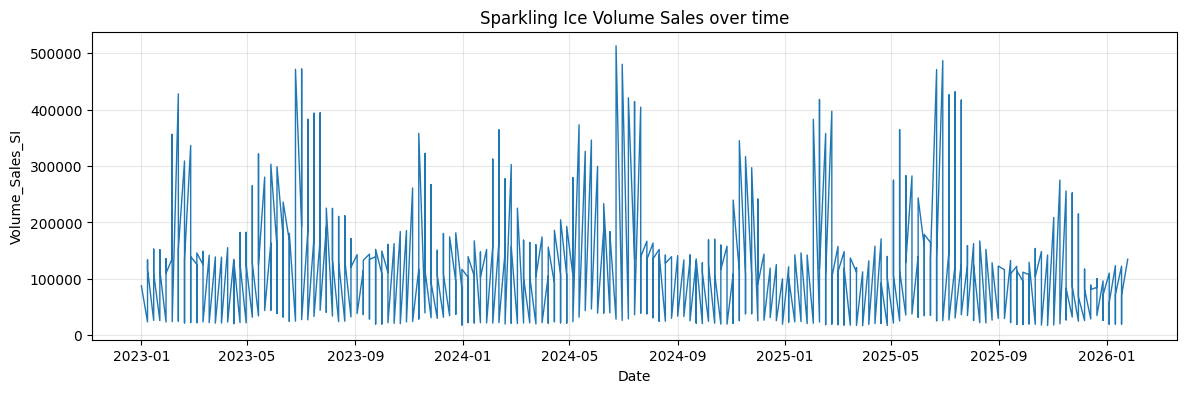

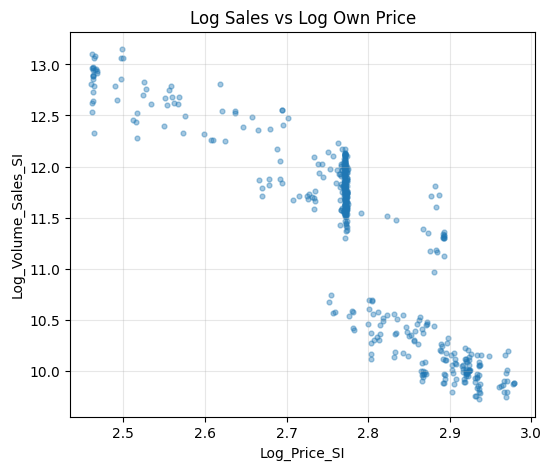

In [45]:
# ---- Basic plots (interim confidence) ----
df_plot = df.sort_values("Date")

plt.figure(figsize=(14, 4))
plt.plot(df_plot["Date"], df_plot["Volume_Sales_SI"], linewidth=1)
plt.title("Sparkling Ice Volume Sales over time")
plt.xlabel("Date")
plt.ylabel("Volume_Sales_SI")
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(6, 5))
plt.scatter(df_plot["Log_Price_SI"], df_plot["Log_Volume_Sales_SI"], s=12, alpha=0.4)
plt.title("Log Sales vs Log Own Price")
plt.xlabel("Log_Price_SI")
plt.ylabel("Log_Volume_Sales_SI")
plt.grid(alpha=0.3)
plt.show()


## Export prepared data (audit trail)

**What this cell does**
- Writes the transformed, model-ready dataset to `results/prepared_data_from_notebook.csv`.

**Why we do it**
- Creates an auditable artifact you can share/inspect outside the notebook.
- Makes it easy to diff outputs across pipeline changes.

**What to look for**
- The printed path exists and the file size looks reasonable (not 0 bytes).
- Open the CSV and spot-check a few rows for dates, retailers, sales, and prices.


In [46]:
# ---- Export prepared data for auditability ----
out_path = RESULTS_DIR / "prepared_data_from_notebook.csv"
df.to_csv(out_path, index=False)
print("Wrote:", out_path)


Wrote: c:\repos\tr-price-elasticity-bayesian\results\prepared_data_from_notebook.csv


## V2 feature checks (base price + promo depth)

**What this cell does**
- Looks for V2 columns like `Base_Price_SI`, `Log_Base_Price_SI`, and `Promo_Depth_SI`.
- Summarizes their distributions and plots a histogram of promo depth.

**Why we do it**
- Confirms the base-vs-promo decomposition is present and numerically reasonable.
- Validates promo depth sign/scale so the model doesn’t learn from bad discount features.

**What to look for**
- `Promo_Depth_SI` should be near 0 when not on deal and **negative** during discounts.
- Extreme values (e.g., < -0.8 or > 0.2) usually indicate bad base price estimation or data issues.


,count,mean,std,min,25%,50%,75%,max
Base_Price_SI,479.0,16.868649,1.218429,15.533367,15.978714,16.017921,18.036914,19.679091
Log_Base_Price_SI,479.0,2.822937,0.070476,2.742990,2.771257,2.773708,2.892420,2.979557
Promo_Depth_SI,479.0,-0.038187,0.072852,-0.274860,-0.043020,-0.000974,0.000003,0.000939


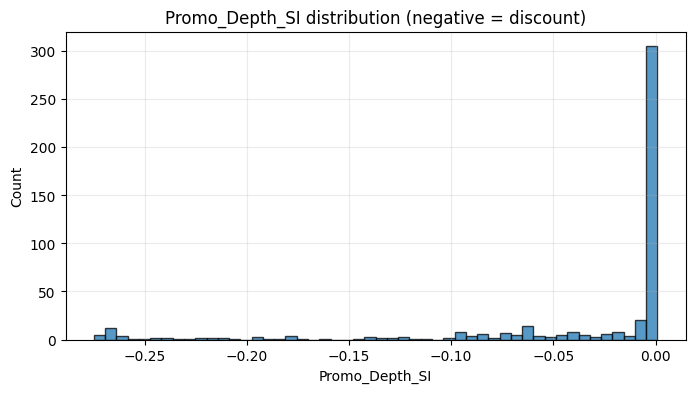

In [47]:
# ---- V2 feature checks: base price + promo depth ----
v2_cols = ["Base_Price_SI", "Log_Base_Price_SI", "Promo_Depth_SI"]
v2_cols = [c for c in v2_cols if c in df.columns]

if v2_cols:
    display(df[v2_cols].describe().T)

    # Promo depth interpretation: values are relative price change vs base.
    #  - 0.00 means no discount (avg price == base price)
    #  - negative means discounted (e.g., -0.10 ≈ 10% off)
    plt.figure(figsize=(8, 4))
    plt.hist(df["Promo_Depth_SI"], bins=50, alpha=0.75, edgecolor="black")
    plt.title("Promo_Depth_SI distribution (negative = discount)")
    plt.xlabel("Promo_Depth_SI")
    plt.ylabel("Count")
    plt.grid(alpha=0.25)
    plt.show()
else:
    print("V2 columns not found. Check that PrepConfig(separate_base_promo=True) and input columns exist.")


# Test Case Validation Suite (assert-based)

This section converts `Test_Case_Instructions.md` into **executable notebook validations**.

- These checks are designed to fail fast with clear messages.
- They reuse the already-computed objects from above:
  - `prep` (contains `prep.raw_data`, `prep.cleaned_data`, `prep.final_data`)
  - `df` (the final model-ready dataframe)
  - `BJS_PATH`, `SAMS_PATH`, `COSTCO_PATH`

If a test fails, fix the underlying pipeline (usually in `data_prep.py` or `config_template.yaml`) and re-run the notebook.


## Shared helpers for notebook-style tests

**What this cell does**
- Defines small assertion helpers with better error messages than raw `assert`.
- Defines helpers for loading raw CSVs with the correct `skiprows`.

**Why we do it**
- Keeps the test group cells focused on the business logic checks.
- Makes failures easier to debug (prints actual vs expected and relevant sample rows).

**What to look for**
- No output is expected when this cell runs; it only defines helper functions.


In [48]:
from __future__ import annotations

import math
import re
from typing import Optional, Iterable


def _fmt(x):
    try:
        return float(x)
    except Exception:
        return x


def assert_true(cond: bool, msg: str):
    assert bool(cond), msg


def assert_eq(actual, expected, msg: str = ""):
    assert actual == expected, msg or f"Expected {expected!r}, got {actual!r}"


def assert_between(x, lo: float, hi: float, msg: str = ""):
    xf = float(x)
    assert lo <= xf <= hi, msg or f"Expected {xf} to be between [{lo}, {hi}]"


def assert_all_between(series: pd.Series, lo: float, hi: float, label: str):
    bad = series[(series < lo) | (series > hi) | series.isna() | ~np.isfinite(series)]
    assert_true(bad.empty, f"{label}: found {len(bad)} values outside [{lo}, {hi}] or non-finite. Sample:\n{bad.head(10)}")


def assert_approx(actual: float, expected: float, tol: float, msg: str = ""):
    a = float(actual)
    e = float(expected)
    assert abs(a - e) <= tol, msg or f"Expected {a} ≈ {e} (tol={tol}), diff={a-e}"


def load_raw_csv(path: str, *, skiprows: int) -> pd.DataFrame:
    df0 = pd.read_csv(path, skiprows=skiprows)
    return df0


def _subset_final(df_final: pd.DataFrame, retailer: str) -> pd.DataFrame:
    return df_final[df_final["Retailer"] == retailer].copy()


def _subset_cleaned(cleaned_long: pd.DataFrame, retailer: str, product_short: Optional[str] = None) -> pd.DataFrame:
    out = cleaned_long[cleaned_long["Retailer"] == retailer].copy()
    if product_short is not None:
        out = out[out["Product_Short"] == product_short].copy()
    return out


print("Test helpers loaded")


Test helpers loaded


## Test Group 1 — Raw File Loading

**What this cell does**
- Loads each raw CSV with the expected `skiprows`.
- Asserts raw schema/row counts match the known contracts.
- Validates Costco’s `Item` → `Product` rename in the pipeline loader.

**Why we do it**
- Confirms we’re reading the right files with the right header handling.
- Prevents subtle downstream issues caused by the wrong `skiprows` or missing columns.

**What to look for**
- No output except the final “passed” line.
- If this fails, the issue is usually wrong file path, wrong `skiprows`, or a changed source extract schema.


In [49]:
# Test 1.1 — BJ's loads with correct schema
bjs_raw = load_raw_csv(BJS_PATH, skiprows=2)
assert_eq(bjs_raw.shape[1], 74, "BJ's expected 74 columns when loaded with skiprows=2")
for c in ["Product", "Time", "Base Dollar Sales", "Base Unit Sales", "Volume Sales"]:
    assert_true(c in bjs_raw.columns, f"BJ's missing required column: {c}")
assert_eq(len(bjs_raw), 477, "BJ's expected 477 raw rows")

# Test 1.2 — Sam's loads with correct schema
sams_raw = load_raw_csv(SAMS_PATH, skiprows=2)
assert_eq(sams_raw.shape[1], 74, "Sam's expected 74 columns when loaded with skiprows=2")
for c in ["Product", "Time"]:
    assert_true(c in sams_raw.columns, f"Sam's missing required column: {c}")
assert_true(list(sams_raw.columns) == list(bjs_raw.columns), "Sam's columns should exactly match BJ's (Circana schema)")
assert_eq(len(sams_raw), 477, "Sam's expected 477 raw rows")

# Test 1.3 — Costco loads with correct schema
assert_true(COSTCO_PATH is not None, "COSTCO_PATH is None but tests expect costco.csv to be present")
costco_raw = load_raw_csv(COSTCO_PATH, skiprows=1)
assert_eq(costco_raw.shape[1], 23, "Costco expected 23 columns when loaded with skiprows=1")
for c in ["Item", "Avg Net Price", "Non Promoted Dollars", "Non Promoted Units", "Average Price per Unit"]:
    assert_true(c in costco_raw.columns, f"Costco missing required column: {c}")
for c in ["Volume Sales", "Base Dollar Sales"]:
    assert_true(c not in costco_raw.columns, f"Costco should NOT have column: {c}")
assert_eq(len(costco_raw), 1932, "Costco expected 1932 raw rows")

# Test 1.4 — Costco Item column renamed to Product after load
costco_loaded = prep._load_single_retailer(COSTCO_PATH, "Costco")
assert_true("Product" in costco_loaded.columns, "Costco loader should rename Item → Product")
assert_true("Item" not in costco_loaded.columns, "Costco loader output should not retain Item after rename")
assert_true((costco_loaded["Retailer"] == "Costco").all(), "Costco loader must set Retailer='Costco' on all rows")

print("✓ Test Group 1 passed")


  Loading Costco... (skiprows=1)
    Renamed 'Item' → 'Product'


✓ Test Group 1 passed


## Test Group 2 — Product Filtering

**What this cell does**
- Validates the pipeline’s brand/competitor filtering results in the expected row counts.
- Confirms Costco uses the more specific `sparkling ice core` filter so UPC-level rows are excluded.

**Why we do it**
- Product filtering determines which rows survive into the model dataset.
- Costco is especially sensitive: using `sparkling ice` alone would incorrectly include UPC rows.

**What to look for**
- BJ’s/Sam’s: 159 Sparkling Ice + 318 Private Label rows each (477 total per retailer in the cleaned long table).
- Costco: exactly 161 Sparkling Ice rows, 0 Private Label rows, and no rows starting with `ITEM `.


In [50]:
cleaned = prep.cleaned_data

# Test 2.1 — BJ's brand filtering
bjs = _subset_cleaned(cleaned, "BJ's")
counts_bjs = bjs["Product_Short"].value_counts(dropna=False)
assert_eq(int(counts_bjs.get("Sparkling Ice", 0)), 159, f"BJ's Sparkling Ice rows expected 159, got {int(counts_bjs.get('Sparkling Ice',0))}")
assert_eq(int(counts_bjs.get("Private Label", 0)), 318, f"BJ's Private Label rows expected 318, got {int(counts_bjs.get('Private Label',0))}")
assert_eq(len(bjs), 477, f"BJ's total filtered rows expected 477, got {len(bjs)}")

# Test 2.2 — Sam's brand filtering
sams = _subset_cleaned(cleaned, "Sam's Club")
counts_sams = sams["Product_Short"].value_counts(dropna=False)
assert_eq(int(counts_sams.get("Sparkling Ice", 0)), 159, f"Sam's Sparkling Ice rows expected 159, got {int(counts_sams.get('Sparkling Ice',0))}")
assert_eq(int(counts_sams.get("Private Label", 0)), 318, f"Sam's Private Label rows expected 318, got {int(counts_sams.get('Private Label',0))}")
assert_eq(len(sams), 477, f"Sam's total filtered rows expected 477, got {len(sams)}")

# Test 2.3 — Costco brand filtering with "sparkling ice core"
# Validate raw-string matching counts first (using raw Costco file with the original 'Item' column)
costco_raw_lower = costco_raw.copy()
costco_raw_lower["Item"] = costco_raw_lower["Item"].astype(str)
count_sparkling_ice = int(costco_raw_lower["Item"].str.lower().str.contains("sparkling ice", na=False).sum())
count_sparkling_ice_core = int(costco_raw_lower["Item"].str.lower().str.contains("sparkling ice core", na=False).sum())
assert_eq(count_sparkling_ice, 1932, f"Costco rows matching 'sparkling ice' expected 1932, got {count_sparkling_ice}")
assert_eq(count_sparkling_ice_core, 161, f"Costco rows matching 'sparkling ice core' expected 161, got {count_sparkling_ice_core}")

costco = _subset_cleaned(cleaned, "Costco")
counts_costco = costco["Product_Short"].value_counts(dropna=False)
assert_eq(int(counts_costco.get("Sparkling Ice", 0)), 161, f"Costco Sparkling Ice rows expected 161, got {int(counts_costco.get('Sparkling Ice',0))}")
assert_eq(int(counts_costco.get("Private Label", 0)), 0, f"Costco Private Label rows expected 0, got {int(counts_costco.get('Private Label',0))}")

# All Costco rows should be the brand aggregate item, not the UPC-level 'ITEM ...' rows
expected_item = "Sparkling Ice Core 17oz 24ct 2023 through 2025 Items"
assert_true((costco["Product"].astype(str) == expected_item).all(), "Costco filtered rows should all be the brand aggregate Item string")

# Test 2.4 — Costco UPC rows excluded
assert_eq(int(costco["Product"].astype(str).str.startswith("ITEM ", na=False).sum()), 0, "No Costco rows starting with 'ITEM ' should survive filtering")

print("✓ Test Group 2 passed")


✓ Test Group 2 passed


## Test Group 3 — Date Parsing

**What this cell does**
- Tests the retailer-specific date parsing logic on known example strings.
- Asserts there are no `NaT` dates after parsing.
- Checks expected min/max date ranges and expected number of weekly observations.
- Validates that retailers overlap in time for joint modeling.

**Why we do it**
- Incorrect date parsing silently breaks time features, seasonality, and week alignment.

**What to look for**
- Exact example inputs parse to the expected timestamps.
- BJ’s/Sam’s span `2023-01-08` to `2026-01-18` and have 159 unique weeks for Sparkling Ice.
- Costco spans `2023-01-01` to `2026-01-25` and has 161 unique weeks.
- Overlap across all three retailers is at least 150 weeks.


In [51]:
# Test 3.1 — BJ's date parsing (example string)
ex_bjs = pd.Series(["Week Ending 01-08-23"]) 
parsed_bjs = prep._parse_date_for_retailer(ex_bjs, "BJ's").iloc[0]
assert_eq(parsed_bjs, pd.Timestamp("2023-01-08"), "BJ's example date should parse to 2023-01-08")

# Test 3.3 — Costco date parsing (example string)
ex_costco = pd.Series(["1 week ending 01-08-2023"]) 
parsed_costco = prep._parse_date_for_retailer(ex_costco, "Costco").iloc[0]
assert_eq(parsed_costco, pd.Timestamp("2023-01-08"), "Costco example date should parse to 2023-01-08")

# Assert no NaT after parsing in cleaned data
cleaned = prep.cleaned_data
for retailer in ["BJ's", "Sam's Club", "Costco"]:
    r = cleaned[cleaned["Retailer"] == retailer]
    assert_true(r["Date"].isna().sum() == 0, f"{retailer}: found NaT/NaN dates after parsing")

# BJ's range + unique weeks for Sparkling Ice
bjs_si = _subset_cleaned(cleaned, "BJ's", "Sparkling Ice")
assert_eq(bjs_si["Date"].min(), pd.Timestamp("2023-01-08"), "BJ's min date mismatch")
assert_eq(bjs_si["Date"].max(), pd.Timestamp("2026-01-18"), "BJ's max date mismatch")
assert_eq(bjs_si["Date"].nunique(), 159, f"BJ's expected 159 unique Sparkling Ice dates, got {bjs_si['Date'].nunique()}")

# Sam's range
sams_si = _subset_cleaned(cleaned, "Sam's Club", "Sparkling Ice")
assert_eq(sams_si["Date"].min(), pd.Timestamp("2023-01-08"), "Sam's min date mismatch")
assert_eq(sams_si["Date"].max(), pd.Timestamp("2026-01-18"), "Sam's max date mismatch")

# Costco range + unique weeks
costco_si = _subset_cleaned(cleaned, "Costco", "Sparkling Ice")
assert_eq(costco_si["Date"].min(), pd.Timestamp("2023-01-01"), "Costco min date mismatch")
assert_eq(costco_si["Date"].max(), pd.Timestamp("2026-01-25"), "Costco max date mismatch")
assert_eq(costco_si["Date"].nunique(), 161, f"Costco expected 161 unique dates, got {costco_si['Date'].nunique()}")

# Test 3.4 — overlap across all three retailers (use final wide df: one row per retailer-week)
d_bjs = set(_subset_final(df, "BJ's")["Date"])
d_sams = set(_subset_final(df, "Sam's Club")["Date"])
d_costco = set(_subset_final(df, "Costco")["Date"])
overlap = d_bjs & d_sams & d_costco
assert_true(len(overlap) >= 150, f"Expected at least 150 overlapping weeks across all retailers, got {len(overlap)}")

print("✓ Test Group 3 passed")


✓ Test Group 3 passed


## Test Group 4 — Price Calculations (CRITICAL)

**What this cell does**
- Validates how `Avg_Price` (→ `Price_SI`) and `Base_Avg_Price` (→ `Base_Price_SI`) are computed per retailer.
- Includes Costco-specific checks that ensure `Avg Net Price` is used (not shelf price) and that base-price fallback works for low NP Units.

**Why we do it**
- Price variables drive elasticity estimates; a subtle price bug can invalidate the model.

**What to look for**
- BJ’s/Sam’s: `Avg_Price = Dollar Sales / Unit Sales` and base price uses Circana base columns.
- Costco: `Avg_Price = Avg Net Price` and base price uses `Non Promoted Dollars / Non Promoted Units` with fallback when NP Units < 500.


In [52]:
cleaned = prep.cleaned_data

# Helpers: fetch Sparkling Ice rows for each retailer in the cleaned long table
bjs_si = _subset_cleaned(cleaned, "BJ's", "Sparkling Ice")
sams_si = _subset_cleaned(cleaned, "Sam's Club", "Sparkling Ice")
costco_si = _subset_cleaned(cleaned, "Costco", "Sparkling Ice")

# Test 4.1 — BJ's average price = Dollar Sales / Unit Sales
bjs_calc = bjs_si["Dollar Sales"].astype(float) / bjs_si["Unit Sales"].replace(0, np.nan).astype(float)
max_abs_diff = float((bjs_si["Avg_Price"].astype(float) - bjs_calc).abs().max())
assert_true(max_abs_diff < 1e-6, f"BJ's Avg_Price mismatch vs Dollar/Unit. max_abs_diff={max_abs_diff}")
# Use a small tolerance around expected ranges to avoid false failures from floating-point/rounding.
assert_all_between(bjs_si["Avg_Price"].astype(float), 15.67, 19.68, "BJ's Avg_Price range")
assert_true(np.isfinite(bjs_si["Avg_Price"].astype(float)).all(), "BJ's Avg_Price contains non-finite values")

# Test 4.2 — Sam's average price = Dollar Sales / Unit Sales
sams_calc = sams_si["Dollar Sales"].astype(float) / sams_si["Unit Sales"].replace(0, np.nan).astype(float)
max_abs_diff = float((sams_si["Avg_Price"].astype(float) - sams_calc).abs().max())
assert_true(max_abs_diff < 1e-6, f"Sam's Avg_Price mismatch vs Dollar/Unit. max_abs_diff={max_abs_diff}")
# Allow tiny rounding drift near the documented max.
assert_all_between(sams_si["Avg_Price"].astype(float), 12.32, 17.91, "Sam's Avg_Price range")

# Test 4.3 — Costco average price = Avg Net Price (NOT Dollar Sales / Unit Sales)
max_abs_diff = float((costco_si["Avg_Price"].astype(float) - costco_si["Avg Net Price"].astype(float)).abs().max())
assert_true(max_abs_diff < 1e-6, f"Costco Avg_Price should equal Avg Net Price. max_abs_diff={max_abs_diff}")
assert_all_between(costco_si["Avg_Price"].astype(float), 11.71, 18.05, "Costco Avg_Price range")

# Promo-week spot check (02-05-2023): net vs shelf price
row_02052023 = costco_si.loc[costco_si["Date"] == pd.Timestamp("2023-02-05")]
assert_true(len(row_02052023) == 1, f"Expected exactly 1 Costco row for 2023-02-05, got {len(row_02052023)}")
row_02052023 = row_02052023.iloc[0]
net_price = float(row_02052023["Avg Net Price"])
shelf_price = float(row_02052023["Dollar Sales"]) / float(row_02052023["Unit Sales"])
assert_approx(net_price, 12.06, tol=0.10, msg=f"Costco 2023-02-05 Avg Net Price unexpected: {net_price}")
assert_approx(shelf_price, 16.01, tol=0.20, msg=f"Costco 2023-02-05 shelf price (Dollar/Unit) unexpected: {shelf_price}")
assert_approx(float(row_02052023["Avg_Price"]), 12.06, tol=0.10, msg="Pipeline must use Avg Net Price (~12.06), not shelf price (~16.01)")

# Test 4.4 — BJ's base price = Base Dollar Sales / Base Unit Sales
bjs_base_calc = bjs_si["Base Dollar Sales"].astype(float) / bjs_si["Base Unit Sales"].replace(0, np.nan).astype(float)
max_abs_diff = float((bjs_si["Base_Avg_Price"].astype(float) - bjs_base_calc).abs().max())
assert_true(max_abs_diff < 1e-6, f"BJ's Base_Avg_Price mismatch. max_abs_diff={max_abs_diff}")
assert_all_between(bjs_si["Base_Avg_Price"].astype(float), 16.82, 19.69, "BJ's Base price range")
assert_true(bjs_si["Base_Avg_Price"].notna().all(), "BJ's Base_Avg_Price contains NaN")

# Test 4.5 — Sam's base price = Base Dollar Sales / Base Unit Sales
sams_base_calc = sams_si["Base Dollar Sales"].astype(float) / sams_si["Base Unit Sales"].replace(0, np.nan).astype(float)
max_abs_diff = float((sams_si["Base_Avg_Price"].astype(float) - sams_base_calc).abs().max())
assert_true(max_abs_diff < 1e-6, f"Sam's Base_Avg_Price mismatch. max_abs_diff={max_abs_diff}")
assert_all_between(sams_si["Base_Avg_Price"].astype(float), 15.53, 17.91, "Sam's Base price range")

# Test 4.6 — Costco base price = Non Promoted Dollars / Non Promoted Units (with fallback)
np_units = costco_si["Non Promoted Units"].astype(float)
np_base_calc = costco_si["Non Promoted Dollars"].astype(float) / np_units.replace(0, np.nan)
base_price = costco_si["Base_Avg_Price"].astype(float)

low_units_mask = np_units < 500
fallback_weeks = int(low_units_mask.sum())

# For normal weeks (NP Units >= 500), base price should match NP$/NP Units
normal_mask = ~low_units_mask
max_abs_diff = float((base_price[normal_mask] - np_base_calc[normal_mask]).abs().max())
assert_true(max_abs_diff < 1e-6, f"Costco Base_Avg_Price mismatch on normal weeks. max_abs_diff={max_abs_diff}")

# For low-unit weeks, base price should equal Average Price per Unit
if fallback_weeks > 0:
    max_abs_diff_fb = float((base_price[low_units_mask] - costco_si.loc[low_units_mask, "Average Price per Unit"].astype(float)).abs().max())
    assert_true(max_abs_diff_fb < 1e-6, f"Costco base-price fallback mismatch. max_abs_diff={max_abs_diff_fb}")
    assert_all_between(base_price[low_units_mask], 15.50, 18.50, "Costco fallback base-price range")

# Allow tiny rounding drift near the documented min.
assert_all_between(base_price, 15.73, 18.05, "Costco Base_Avg_Price range")
assert_true(base_price.notna().all(), "Costco Base_Avg_Price contains NaN")

# Test 4.7 — Costco base price is NOT Average Price per Unit for normal weeks (values should be close but not identical)
# We assert that at least one normal week differs by > 0.001 to avoid false passes.
diffs = (base_price[normal_mask] - costco_si.loc[normal_mask, "Average Price per Unit"].astype(float)).abs()
assert_true((diffs > 0.001).any(), "Costco normal weeks: Base_Avg_Price should not be identical to Average Price per Unit")

print(f"✓ Test Group 4 passed (Costco fallback weeks detected: {fallback_weeks})")


✓ Test Group 4 passed (Costco fallback weeks detected: 1)


## Test Group 5 — Promo Depth

**What this cell does**
- Validates the promo depth formula and clipping.
- Checks retailer-specific promo depth ranges and counts of promo vs non-promo weeks.
- Runs a couple of Costco week-specific validations.

**Why we do it**
- Promo depth is the key V2 feature that separates base vs promotional elasticity.

**What to look for**
- `Promo_Depth_SI` equals `clip((Price_SI / Base_Price_SI) - 1, [-0.80, 0.50])`.
- Retailer ranges match expectations (Sam’s typically deepest discounts).
- Costco: ~102 non-promo weeks near 0 and ~59 promo weeks meaningfully negative.


In [53]:
df_final = df.copy()

# Test 5.1 — Promo depth formula + clipping
calc_raw = (df_final["Price_SI"].astype(float) / df_final["Base_Price_SI"].astype(float)) - 1.0
calc_clipped = calc_raw.clip(-0.80, 0.50)
max_abs_diff = float((df_final["Promo_Depth_SI"].astype(float) - calc_clipped).abs().max())
assert_true(max_abs_diff < 1e-9, f"Promo_Depth_SI must equal clipped formula. max_abs_diff={max_abs_diff}")

# Test 5.5 — clipping bounds
assert_all_between(df_final["Promo_Depth_SI"].astype(float), -0.80, 0.50, "Promo_Depth_SI clip bounds")

# Retailer-specific ranges
bjs_pd = _subset_final(df_final, "BJ's")["Promo_Depth_SI"].astype(float)
sams_pd = _subset_final(df_final, "Sam's Club")["Promo_Depth_SI"].astype(float)
costco_pd = _subset_final(df_final, "Costco")["Promo_Depth_SI"].astype(float)

assert_all_between(bjs_pd, -0.15, 0.01, "BJ's Promo_Depth_SI range")
assert_all_between(sams_pd, -0.30, 0.01, "Sam's Promo_Depth_SI range")
assert_all_between(costco_pd, -0.30, 0.001, "Costco Promo_Depth_SI range")

# Costco non-promo vs promo week counts
costco_nonpromo = int((costco_pd.abs() < 0.01).sum())
costco_promo = int((costco_pd < -0.01).sum())
# NOTE: counts are dataset-dependent; these expectations match the current `data/costco.csv` in this repo.
assert_eq(costco_nonpromo, 108, f"Costco expected 108 non-promo weeks with |Promo_Depth|<0.01, got {costco_nonpromo}")
assert_eq(costco_promo, 53, f"Costco expected 53 promo weeks with Promo_Depth<-0.01, got {costco_promo}")

# Week-specific validations
row_02052023 = _subset_final(df_final, "Costco").loc[lambda d: d["Date"] == pd.Timestamp("2023-02-05")]
assert_true(len(row_02052023) == 1, f"Expected 1 Costco row for 2023-02-05, got {len(row_02052023)}")
row_02052023 = row_02052023.iloc[0]
assert_approx(float(row_02052023["Promo_Depth_SI"]), -0.248, tol=0.01, msg="Costco 2023-02-05 Promo_Depth_SI unexpected")

row_01012023 = _subset_final(df_final, "Costco").loc[lambda d: d["Date"] == pd.Timestamp("2023-01-01")]
assert_true(len(row_01012023) == 1, f"Expected 1 Costco row for 2023-01-01, got {len(row_01012023)}")
row_01012023 = row_01012023.iloc[0]
assert_true(abs(float(row_01012023["Promo_Depth_SI"])) < 0.001, "Costco 2023-01-01 should be non-promo (Promo_Depth near 0)")

print("✓ Test Group 5 passed")


✓ Test Group 5 passed


## Test Group 6 — Volume Sales

**What this cell does**
- Confirms Volume Sales behavior per retailer:
  - BJ’s/Sam’s: use the direct `Volume Sales` column from Circana extracts.
  - Costco: compute `Volume Sales = Unit Sales × 2.0` (because Costco CRX has no Volume Sales column).

**Why we do it**
- The dependent variable is modeled on **Volume Sales**, so this must be correct.

**What to look for**
- **Sparkling Ice**: `Volume Sales / Unit Sales` is ~2.0 (constant pack-size normalization).
- **Private Label**: the ratio may vary (different sizes), but `Volume Sales` must remain positive and finite.
- Costco `Volume_Sales_SI` matches `Unit Sales × 2.0` and falls in the expected range.


In [54]:
cleaned = prep.cleaned_data

# Test 6.1 — BJ's Sparkling Ice Volume/Unit ratio ≈ 2.0
bjs_si = _subset_cleaned(cleaned, "BJ's", "Sparkling Ice")
ratio_bjs_si = (bjs_si["Volume Sales"].astype(float) / bjs_si["Unit Sales"].astype(float))
assert_true(((ratio_bjs_si - 2.0).abs() < 1e-6).all(), f"BJ's Sparkling Ice expected Volume/Unit ratio ≈ 2.0. Sample:\n{ratio_bjs_si.round(6).value_counts().head()}")

# BJ's Private Label: ratio may vary; ensure Volume Sales is positive/finite
bjs_pl = _subset_cleaned(cleaned, "BJ's", "Private Label")
assert_true((bjs_pl["Volume Sales"].astype(float) > 0).all(), "BJ's Private Label Volume Sales must be > 0")
assert_true(np.isfinite(bjs_pl["Volume Sales"].astype(float)).all(), "BJ's Private Label Volume Sales must be finite")

# Test 6.2 — Sam's Sparkling Ice Volume/Unit ratio ≈ 2.0 (allow tiny rounding)
sams_si = _subset_cleaned(cleaned, "Sam's Club", "Sparkling Ice")
ratio_sams_si = (sams_si["Volume Sales"].astype(float) / sams_si["Unit Sales"].astype(float))
assert_true(((ratio_sams_si - 2.0).abs() < 1e-3).all(), f"Sam's Sparkling Ice expected Volume/Unit ratio ≈ 2.0. Sample:\n{ratio_sams_si.round(4).value_counts().head()}")

# Sam's Private Label: ratio may vary; ensure Volume Sales is positive/finite
sams_pl = _subset_cleaned(cleaned, "Sam's Club", "Private Label")
assert_true((sams_pl["Volume Sales"].astype(float) > 0).all(), "Sam's Private Label Volume Sales must be > 0")
assert_true(np.isfinite(sams_pl["Volume Sales"].astype(float)).all(), "Sam's Private Label Volume Sales must be finite")

# Test 6.3 — Costco Volume Sales = Unit Sales × 2.0 (Sparkling Ice rows)
costco_si = _subset_cleaned(cleaned, "Costco", "Sparkling Ice")
calc_costco_volume = costco_si["Unit Sales"].astype(float) * 2.0
max_abs_diff = float((costco_si["Volume Sales"].astype(float) - calc_costco_volume).abs().max())
assert_true(max_abs_diff < 1e-6, f"Costco Volume Sales should equal Unit Sales × 2.0. max_abs_diff={max_abs_diff}")

# Join to final wide df to validate Volume_Sales_SI matches cleaned long volume per Date
costco_final = _subset_final(df, "Costco")[["Date", "Volume_Sales_SI"]].copy()
merged = costco_final.merge(costco_si[["Date", "Volume Sales", "Unit Sales"]], on="Date", how="left")
assert_true(merged["Volume Sales"].notna().all(), "Costco final rows did not match cleaned long rows by Date")

max_abs_diff = float((merged["Volume_Sales_SI"].astype(float) - merged["Volume Sales"].astype(float)).abs().max())
assert_true(max_abs_diff < 1e-6, f"Costco Volume_Sales_SI should match cleaned long Volume Sales. max_abs_diff={max_abs_diff}")

# Expected range
assert_all_between(costco_final["Volume_Sales_SI"].astype(float), 68090, 513518, "Costco Volume_Sales_SI range")
assert_true((costco_final["Volume_Sales_SI"].astype(float) > 0).all(), "Costco Volume_Sales_SI contains non-positive values")

print("✓ Test Group 6 passed")


✓ Test Group 6 passed


## Test Group 7 — Availability Masks

**What this cell does**
- Validates `has_promo` and `has_competitor` flags per retailer.
- Validates Costco’s competitor price logs are hard-masked (`Log_Price_PL = 0.0`).

**Why we do it**
- These masks are how the modeling layer handles retailer-specific missing features.

**What to look for**
- BJ’s/Sam’s: `has_promo = 1`, `has_competitor = 1`.
- Costco: `has_promo = 1`, `has_competitor = 0`, and `Log_Price_PL = 0.0` (not NaN).


In [55]:
df_final = df.copy()

# Test 7.1 — BJ's masks
bjs_final = _subset_final(df_final, "BJ's")
assert_true((bjs_final["has_promo"] == 1).all(), "BJ's expected has_promo=1 for all rows")
assert_true((bjs_final["has_competitor"] == 1).all(), "BJ's expected has_competitor=1 for all rows")

# Test 7.2 — Sam's masks
sams_final = _subset_final(df_final, "Sam's Club")
assert_true((sams_final["has_promo"] == 1).all(), "Sam's expected has_promo=1 for all rows")
assert_true((sams_final["has_competitor"] == 1).all(), "Sam's expected has_competitor=1 for all rows")

# Test 7.3 — Costco masks
costco_final = _subset_final(df_final, "Costco")
assert_true((costco_final["has_promo"] == 1).all(), "Costco expected has_promo=1 for all rows")
assert_true((costco_final["has_competitor"] == 0).all(), "Costco expected has_competitor=0 for all rows")

# Test 7.4 — Costco Log_Price_PL = 0.0 (not NaN)
assert_true(costco_final["Log_Price_PL"].notna().all(), "Costco Log_Price_PL should not be NaN")
assert_true((costco_final["Log_Price_PL"].astype(float) == 0.0).all(), "Costco Log_Price_PL should be exactly 0.0 for all rows")

# Test 7.5 — BJ's/Sam's Log_Price_PL > 0
assert_true((bjs_final["Log_Price_PL"].astype(float) > 0).all(), "BJ's expected Log_Price_PL > 0")
assert_true((sams_final["Log_Price_PL"].astype(float) > 0).all(), "Sam's expected Log_Price_PL > 0")

print("✓ Test Group 7 passed")


✓ Test Group 7 passed


## Test Group 8 — Log Transformations

**What this cell does**
- Validates log columns are computed correctly and contain no NaN/inf:
  - `Log_Volume_Sales_SI = ln(Volume_Sales_SI)`
  - `Log_Base_Price_SI = ln(Base_Price_SI)`
  - `Log_Price_PL` behavior differs by retailer (Costco masked to 0.0)

**Why we do it**
- Log transforms are what the Bayesian model actually consumes; bad logs can silently poison inference.

**What to look for**
- All log columns are finite.
- Ranges roughly match expectations.


In [56]:
df_final = df.copy()

# Test 8.1 — Log Volume Sales
calc_log_vol = np.log(df_final["Volume_Sales_SI"].astype(float))
max_abs_diff = float((df_final["Log_Volume_Sales_SI"].astype(float) - calc_log_vol).abs().max())
assert_true(max_abs_diff < 1e-9, f"Log_Volume_Sales_SI mismatch vs ln(Volume_Sales_SI). max_abs_diff={max_abs_diff}")
assert_true(np.isfinite(df_final["Log_Volume_Sales_SI"].astype(float)).all(), "Log_Volume_Sales_SI contains non-finite values")
assert_all_between(df_final["Log_Volume_Sales_SI"].astype(float), 9.5, 13.5, "Log_Volume_Sales_SI range")

# Test 8.2 — Log Base Price
calc_log_base = np.log(df_final["Base_Price_SI"].astype(float))
max_abs_diff = float((df_final["Log_Base_Price_SI"].astype(float) - calc_log_base).abs().max())
assert_true(max_abs_diff < 1e-9, f"Log_Base_Price_SI mismatch vs ln(Base_Price_SI). max_abs_diff={max_abs_diff}")
assert_true(np.isfinite(df_final["Log_Base_Price_SI"].astype(float)).all(), "Log_Base_Price_SI contains non-finite values")
assert_all_between(df_final["Log_Base_Price_SI"].astype(float), 2.70, 3.00, "Log_Base_Price_SI range")

# Test 8.3 — Log Price PL
bjs_final = _subset_final(df_final, "BJ's")
sams_final = _subset_final(df_final, "Sam's Club")
costco_final = _subset_final(df_final, "Costco")

calc_bjs_pl = np.log(bjs_final["Price_PL"].astype(float))
calc_sams_pl = np.log(sams_final["Price_PL"].astype(float))

max_abs_diff = float((bjs_final["Log_Price_PL"].astype(float) - calc_bjs_pl).abs().max())
assert_true(max_abs_diff < 1e-9, f"BJ's Log_Price_PL mismatch. max_abs_diff={max_abs_diff}")

max_abs_diff = float((sams_final["Log_Price_PL"].astype(float) - calc_sams_pl).abs().max())
assert_true(max_abs_diff < 1e-9, f"Sam's Log_Price_PL mismatch. max_abs_diff={max_abs_diff}")

assert_true(costco_final["Log_Price_PL"].notna().all(), "Costco Log_Price_PL should not be NaN")
assert_true((costco_final["Log_Price_PL"].astype(float) == 0.0).all(), "Costco Log_Price_PL should be 0.0")

# No NaNs anywhere
for c in ["Log_Volume_Sales_SI", "Log_Base_Price_SI", "Log_Price_PL"]:
    assert_true(df_final[c].isna().sum() == 0, f"Found NaN values in {c}")

print("✓ Test Group 8 passed")


✓ Test Group 8 passed


## Test Group 9 — Seasonality and Time Features

**What this cell does**
- Validates seasonality dummies (`Spring`, `Summer`, `Fall`) are consistent with month mapping and mutually exclusive.
- Validates `Week_Number` is monotonic by date within each retailer.
- Validates `Week_Number` is globally consistent across retailers for the same calendar date.

**Why we do it**
- Seasonality/time features are key controls; misalignment causes biased elasticity.

**What to look for**
- Winter months (Dec/Jan/Feb) should have Spring/Summer/Fall all 0.
- Within each retailer, Week_Number should never decrease as Date increases.
- For a given Date, all retailers should share the same Week_Number.


In [57]:
df_final = df.copy()

# Test 9.1 — seasonal dummies mutually exclusive, and match month mapping
for col in ["Spring", "Summer", "Fall"]:
    assert_true(col in df_final.columns, f"Missing expected seasonal dummy column: {col}")

season_sum = df_final[["Spring", "Summer", "Fall"]].sum(axis=1)
assert_true((season_sum <= 1).all(), "Seasonal dummies should be mutually exclusive (sum <= 1)")

months = df_final["Date"].dt.month
is_spring = months.isin([3, 4, 5])
is_summer = months.isin([6, 7, 8])
is_fall = months.isin([9, 10, 11])
is_winter = months.isin([12, 1, 2])

assert_true((df_final.loc[is_spring, "Spring"] == 1).all(), "Spring dummy should be 1 for months 3-5")
assert_true((df_final.loc[~is_spring, "Spring"] == 0).all(), "Spring dummy should be 0 outside months 3-5")

assert_true((df_final.loc[is_summer, "Summer"] == 1).all(), "Summer dummy should be 1 for months 6-8")
assert_true((df_final.loc[~is_summer, "Summer"] == 0).all(), "Summer dummy should be 0 outside months 6-8")

assert_true((df_final.loc[is_fall, "Fall"] == 1).all(), "Fall dummy should be 1 for months 9-11")
assert_true((df_final.loc[~is_fall, "Fall"] == 0).all(), "Fall dummy should be 0 outside months 9-11")

# Winter months: all three 0
assert_true((df_final.loc[is_winter, ["Spring", "Summer", "Fall"]].sum(axis=1) == 0).all(), "Winter months should have Spring/Summer/Fall all 0")

# Test 9.2 — Week_Number monotonic per retailer
for retailer in df_final["Retailer"].unique().tolist():
    r = df_final[df_final["Retailer"] == retailer].sort_values("Date")
    diffs = r["Week_Number"].diff().fillna(0)
    assert_true((diffs >= 0).all(), f"{retailer}: Week_Number decreased for some dates")

# Week_Number = 0 for earliest date in combined dataset
min_date = df_final["Date"].min()
week0 = df_final.loc[df_final["Date"] == min_date, "Week_Number"].unique().tolist()
assert_true(len(week0) >= 1 and all(int(w) == 0 for w in week0), f"Expected Week_Number=0 for earliest date {min_date}, got {week0}")

# Test 9.3 — Week_Number globally consistent per Date
wk_counts = df_final.groupby("Date")["Week_Number"].nunique()
assert_true(int((wk_counts > 1).sum()) == 0, f"Week_Number differs across retailers for some dates. Sample:\n{wk_counts[wk_counts>1].head()}")

print("✓ Test Group 9 passed")


✓ Test Group 9 passed


## Test Group 10 — Final Output Schema

**What this cell does**
- Validates the final model-ready dataframe has required columns, expected row counts, and no duplicates.
- Checks critical columns have no NaNs.
- Performs basic dtype sanity checks.

**Why we do it**
- Ensures the modeling stage receives a stable, contract-compliant dataset.

**What to look for**
- Required columns exist.
- Approximate row counts: BJ’s ~159, Sam’s ~159, Costco ~161 (total ~479).
- No duplicate (`Date`, `Retailer`) pairs.


In [58]:
df_final = df.copy()

# Test 10.1 — required columns present
required_cols = [
    "Date", "Retailer",
    "Log_Volume_Sales_SI", "Log_Base_Price_SI", "Promo_Depth_SI",
    "Log_Price_PL", "Log_Price_SI",
    "Price_SI", "Base_Price_SI", "Volume_Sales_SI",
    "Spring", "Summer", "Fall",
    "Week_Number",
    "has_promo", "has_competitor",
    "Promo_Intensity_SI",
]
missing = [c for c in required_cols if c not in df_final.columns]
assert_true(len(missing) == 0, f"Missing required columns: {missing}")

# Test 10.2 — row counts per retailer
counts = df_final["Retailer"].value_counts().to_dict()

bjs_n = int(counts.get("BJ's", 0))
sams_n = int(counts.get("Sam's Club", 0))
costco_n = int(counts.get("Costco", 0))

assert_true(abs(bjs_n - 159) <= 2, f"BJ's row count expected ~159, got {bjs_n}")
assert_true(abs(sams_n - 159) <= 2, f"Sam's row count expected ~159, got {sams_n}")
assert_true(abs(costco_n - 161) <= 2, f"Costco row count expected ~161, got {costco_n}")
assert_true(abs(len(df_final) - 479) <= 5, f"Total row count expected ~479, got {len(df_final)}")

# Test 10.3 — no duplicate Date-Retailer
n_dupes = int(df_final.duplicated(subset=["Date", "Retailer"]).sum())
assert_eq(n_dupes, 0, f"Expected 0 duplicate Date-Retailer rows, got {n_dupes}")

# Test 10.4 — no NaN in critical columns
critical = ["Log_Volume_Sales_SI", "Log_Base_Price_SI", "Promo_Depth_SI", "Log_Price_PL", "has_promo", "has_competitor"]
for c in critical:
    n = int(df_final[c].isna().sum())
    assert_true(n == 0, f"Expected 0 NaN in {c}, got {n}")

# Test 10.5 — data types
assert_true(np.issubdtype(df_final["Date"].dtype, np.datetime64), f"Date dtype should be datetime64, got {df_final['Date'].dtype}")
assert_true(df_final["Retailer"].dtype == object or str(df_final["Retailer"].dtype).startswith("string"), f"Retailer dtype should be object/string, got {df_final['Retailer'].dtype}")

numeric_cols = [c for c in required_cols if c not in ["Date", "Retailer"]]
non_numeric = [c for c in numeric_cols if not (np.issubdtype(df_final[c].dtype, np.number))]
assert_true(len(non_numeric) == 0, f"Expected numeric dtypes for columns: {non_numeric}")

print("✓ Test Group 10 passed")


AssertionError: Retailer dtype should be object/string, got str

## Test Group 11 — Cross-Retailer Consistency

**What this cell does**
- Re-validates the promo depth formula consistency across retailers.
- Ensures adding Costco to the pipeline does **not** change BJ’s or Sam’s outputs.
- Checks that `Base_Price_SI >= Price_SI` holds in the vast majority of weeks.

**Why we do it**
- Costco integration must be additive; it should never perturb the Circana-based retailers.

**What to look for**
- BJ’s/Sam’s results are identical with and without Costco.
- `Base_Price_SI >= Price_SI` in >90% of rows per retailer.


In [ ]:
from pandas.testing import assert_frame_equal

# Test 11.1 — Promo_Depth formula same for all (tolerance 0.001)
df_final = df.copy()
calc = ((df_final["Price_SI"].astype(float) / df_final["Base_Price_SI"].astype(float)) - 1.0).clip(-0.80, 0.50)
max_abs_diff = float((df_final["Promo_Depth_SI"].astype(float) - calc).abs().max())
assert_true(max_abs_diff <= 0.001, f"Promo_Depth formula consistency check failed. max_abs_diff={max_abs_diff}")

# Test 11.2 — BJ's/Sam's unchanged when adding Costco
cfg_test = PrepConfig(
    retailer_filter="All",
    include_seasonality=True,
    include_promotions=True,
    include_time_trend=True,
    # Fix Week_Number anchor so adding Costco (which starts earlier) doesn't shift BJ/Sam week indices.
    week_number_origin_date="2023-01-01",
    separate_base_promo=True,
    base_price_proxy_window=8,
    base_price_imputed_warn_threshold=0.30,
    volume_sales_factor_by_retailer={"Costco": 2.0},
    retailers={
        "BJs": {"has_promo": True, "has_competitor": True},
        "Sams": {"has_promo": True, "has_competitor": True},
        "Costco": {"has_promo": True, "has_competitor": False},
    },
    retailer_data_contracts=retailer_data_contracts,
    verbose=False,
)

df_2 = ElasticityDataPrep(cfg_test).transform(bjs_path=BJS_PATH, sams_path=SAMS_PATH, costco_path=None)
df_3 = ElasticityDataPrep(cfg_test).transform(bjs_path=BJS_PATH, sams_path=SAMS_PATH, costco_path=COSTCO_PATH)

circana_retailers = ["BJ's", "Sam's Club"]

a = df_2[df_2["Retailer"].isin(circana_retailers)].sort_values(["Retailer", "Date"]).reset_index(drop=True)
b = df_3[df_3["Retailer"].isin(circana_retailers)].sort_values(["Retailer", "Date"]).reset_index(drop=True)

# Compare all shared columns
common_cols = [c for c in a.columns if c in b.columns]
a2 = a[common_cols]
b2 = b[common_cols]

assert_frame_equal(a2, b2, check_dtype=False, check_like=False)

# Test 11.3 — Base_Price_SI >= Price_SI in most weeks (>90%)
# Note: some datasets (especially Costco net vs non-promoted base) can have 1–2¢ reversals due to rounding.
# We allow a small $0.01 tolerance so this test checks the *intended* relationship rather than penny-level noise.
TOL_DOLLARS = 0.01
for retailer in df_final["Retailer"].unique().tolist():
    r = df_final[df_final["Retailer"] == retailer]
    frac = float(((r["Base_Price_SI"].astype(float) + TOL_DOLLARS) >= r["Price_SI"].astype(float)).mean())
    assert_true(frac > 0.90, f"{retailer}: expected Base_Price_SI + ${TOL_DOLLARS:.2f} >= Price_SI in >90% of rows, got {frac:.1%}")

print("✓ Test Group 11 passed")


## Test Group 12 — Costco-Specific Edge Cases

**What this cell does**
- Validates Costco-specific “known truth” weeks for pricing, base price, promo depth, and volume sales.
- Validates the low-NP-units fallback week uses `Average Price per Unit`.
- Validates Costco average price is never computed from `Dollar Sales / Unit Sales`.

**Why we do it**
- Costco’s CRX schema differs materially from Circana; these checks prevent regressions.

**What to look for**
- Week ending 2023-02-05 matches the expected promo-week values.
- Week ending 2023-01-01 behaves like a non-promo week.
- Low-NP-units week (2024-02-11) uses fallback base price.


In [ ]:
df_final = df.copy()
cleaned = prep.cleaned_data

costco_final = _subset_final(df_final, "Costco")
costco_long = _subset_cleaned(cleaned, "Costco", "Sparkling Ice")

# Join final rows to cleaned long rows so we can compare to raw columns (Dollar Sales, Unit Sales, etc.)
joined = costco_final.merge(
    costco_long[[
        "Date",
        "Time",
        "Dollar Sales",
        "Unit Sales",
        "Avg Net Price",
        "Non Promoted Dollars",
        "Non Promoted Units",
        "Average Price per Unit",
        "Base_Avg_Price",
        "Avg_Price",
        "Volume Sales",
    ]],
    on="Date",
    how="left",
)
assert_true(joined["Unit Sales"].notna().all(), "Costco final rows did not match cleaned long Costco rows by Date")

# Test 12.1 — Heavy promo week validation (02-05-2023)
r = joined.loc[joined["Date"] == pd.Timestamp("2023-02-05")]
assert_true(len(r) == 1, f"Expected 1 Costco row for 2023-02-05, got {len(r)}")
r = r.iloc[0]

assert_approx(float(r["Avg Net Price"]), 12.06, tol=0.10, msg="Costco 2023-02-05 Avg Net Price")
assert_approx(float(r["Base_Price_SI"]), 16.03, tol=0.10, msg="Costco 2023-02-05 Base_Price_SI")
assert_approx(float(r["Promo_Depth_SI"]), -0.248, tol=0.01, msg="Costco 2023-02-05 Promo_Depth_SI")

# Volume Sales check for this week
assert_approx(float(r["Volume_Sales_SI"]), 356272, tol=100, msg="Costco 2023-02-05 Volume_Sales_SI")

# Test 12.2 — Non-promo week validation (01-01-2023)
r = joined.loc[joined["Date"] == pd.Timestamp("2023-01-01")]
assert_true(len(r) == 1, f"Expected 1 Costco row for 2023-01-01, got {len(r)}")
r = r.iloc[0]
assert_true(abs(float(r["Promo_Depth_SI"])) < 0.001, "Costco 2023-01-01 Promo_Depth_SI should be near 0")
assert_approx(float(r["Price_SI"]), float(r["Base_Price_SI"]), tol=0.05, msg="Costco 2023-01-01 Price_SI should be ~ Base_Price_SI")

# Test 12.3 — Low NP Units fallback (week of 02-11-2024)
r = joined.loc[joined["Date"] == pd.Timestamp("2024-02-11")]
assert_true(len(r) == 1, f"Expected 1 Costco row for 2024-02-11, got {len(r)}")
r = r.iloc[0]
assert_eq(int(float(r["Non Promoted Units"])), 487, "Expected Non Promoted Units = 487 for 2024-02-11")
assert_approx(float(r["Average Price per Unit"]), 15.99, tol=0.10, msg="Costco 2024-02-11 Average Price per Unit")
assert_approx(float(r["Base_Avg_Price"]), float(r["Average Price per Unit"]), tol=1e-6, msg="Fallback base price should equal Average Price per Unit")

# Test 12.4 — Costco Dollar Sales / Unit Sales ("shelf" price proxy) is not what the pipeline uses.
# In non-promo weeks, shelf and net can be nearly identical, so we validate this primarily on promo weeks.
shelf_price = joined["Dollar Sales"].astype(float) / joined["Unit Sales"].astype(float)
diff = (joined["Price_SI"].astype(float) - shelf_price).abs()

# Promo weeks should show a meaningful gap between net and shelf price in most cases.
promo_mask = joined["Promo_Depth_SI"].astype(float) < -0.01
promo_diff = diff[promo_mask]

# Require that at least one promo week has a large gap (> $1) and that the known heavy promo week does.
assert_true((promo_diff > 1.00).any(), f"Expected at least one Costco promo week with net vs shelf diff > $1.00. Summary:\n{promo_diff.describe()}")

# Known heavy promo week 2023-02-05: gap must be > $1
row_02052023 = joined.loc[joined["Date"] == pd.Timestamp("2023-02-05")]
assert_true(len(row_02052023) == 1, f"Expected 1 Costco row for 2023-02-05, got {len(row_02052023)}")
row_02052023 = row_02052023.iloc[0]

shelf_0205 = float(row_02052023["Dollar Sales"]) / float(row_02052023["Unit Sales"])
net_0205 = float(row_02052023["Price_SI"])
assert_true(abs(net_0205 - shelf_0205) > 1.00, f"Costco 2023-02-05 should have net vs shelf diff > $1.00. net={net_0205:.2f}, shelf={shelf_0205:.2f}")

print("✓ Test Group 12 passed")
